In [1]:
import numpy as np
from games.tictactoe import TickTackToe
from models.mcts import MCTS
from models.resnet import ResNet
import torch
from tqdm import tqdm
from tqdm import trange
import random
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

In [2]:
class DeepZero:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game, args, model)

    def selfPlay(self):
        memory = []
        player = 1
        state = self.game.get_initial_state()

        while True:
            neutral_state = self.game.change_perspective(state, player)
            action_probs = self.mcts.search(neutral_state)

            memory.append((neutral_state, action_probs, player))

            temperature_action_probs = action_probs ** (1/self.args['temperature'])
            action = np.random.choice(self.game.action_size, p = action_probs)

            state = self.game.get_next_state(state, action, player)

            value, is_terminate = self.game.get_value_and_terminated(state, action)

            if is_terminate:
                returnMemory = []
                for hist_neutral_state, hist_action_probs, hist_player in memory:
                    hist_outcome = (value if hist_player == player else self.game.get_opponent_value(value))
                    returnMemory.append((
                        self.game.get_encoded_state(hist_neutral_state),
                        hist_action_probs,
                        hist_outcome
                    ))

                return returnMemory

            player = self.game.get_opponent(player)

    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) -1, batchIdx + self.args['batch_size'])]
            state, policy_target, value_target = zip(*sample)

            state, policy_target, value_target = np.array(state), np.array(policy_target), np.array(value_target).reshape(-1, 1)

            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_target = torch.tensor(policy_target, dtype=torch.float32, device=self.model.device)
            value_target = torch.tensor(value_target, dtype=torch.float32, device=self.model.device)

            out_policy, out_value = self.model(state)

            policy_loss = F.cross_entropy(out_policy, policy_target)
            value_loss = F.mse_loss(out_value, value_target)

            loss = policy_loss + value_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []

            self.model.eval()
            for selfPlay_iteration in trange(self.args['num_selfplay_iterations']):
                memory += self.selfPlay()

            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)

            torch.save(self.model.state_dict(), f"weights/model_{iteration}_{self.game}.pt")
            torch.save(self.optimizer.state_dict(), f"weights/optimizer_{iteration}_{self.game}..pt")

In [5]:
tictactoe = TickTackToe()

device = torch.device("cpu")

model = ResNet(tictactoe, 4, 32, device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

player = 1

args = {
    'C': 2,
    'num_search': 600,
    'num_iterations': 3,
    'batch_size': 16,
    'num_selfplay_iterations': 350,
    'num_epochs': 4,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

deepzero = DeepZero(model, optimizer, tictactoe, args)
deepzero.learn()


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


0.9187695384025574
[[ 1.  0.  1.]
 [ 0.  0.  0.]
 [ 1. -1. -1.]]
tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 1., 1.]],

         [[0., 1., 0.],
          [1., 1., 1.],
          [0., 0., 0.]],

         [[1., 0., 1.],
          [0., 0., 0.],
          [1., 0., 0.]]]])


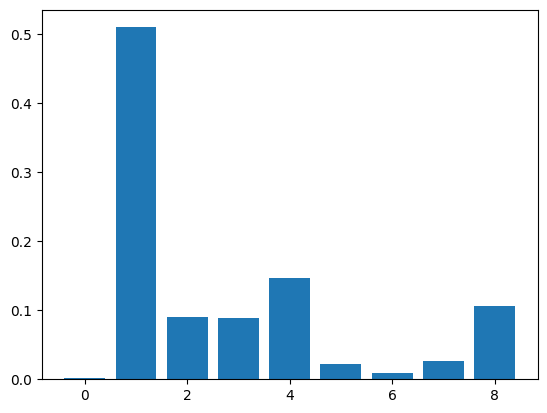

In [9]:
tictactoe = TickTackToe()

state = tictactoe.get_initial_state()
state = tictactoe.get_next_state(state, 2, 1)
state = tictactoe.get_next_state(state, 7, -1)
state = tictactoe.get_next_state(state, 0, 1)
state = tictactoe.get_next_state(state, 8, -1)
state = tictactoe.get_next_state(state, 6, 1)

encode_state = tictactoe.get_encoded_state(state)

tensor_state = torch.tensor(encode_state, device=device).unsqueeze(0)

model = ResNet(tictactoe, 4, 32, device=device)
model.load_state_dict(torch.load("weights/model_2.pt", map_location=device))
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value)
print(state)
print(tensor_state)

plt.bar(range(tictactoe.action_size), policy)
plt.show()

In [ ]:
while True:
    print(state)
    if player == 1:
        valid_moves = tictactoe.get_valid_moves(state)
        print("val_movies", [i for i in range(tictactoe.action_size) if valid_moves[i] == 1])
        action = int(input(f"{player}: "))

        if valid_moves[action] == 0:
            print("action not val")
            continue
    else:
        neutral_state = tictactoe.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)

    state = tictactoe.get_next_state(state, action, player)

    value, is_terminate = tictactoe.get_value_and_terminated(state, action)

    if is_terminate:
        if value == 1:
            print(player, "win")
        else:
             print(player, "lose")
        break

    player = tictactoe.get_opponent(player)

In [ ]:
while True:
    print(state)
    if player == 1:
        valid_moves = tictactoe.get_valid_moves(state)
        neutral_state = tictactoe.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)

        if valid_moves[action] == 0:
            print("action not val")
            continue
    else:
        neutral_state = tictactoe.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)

    state = tictactoe.get_next_state(state, action, player)

    value, is_terminate = tictactoe.get_value_and_terminated(state, action)

    if is_terminate:
        if value == 1:
            print(player, "win")
        else:
            print(player, "lose")
        break

    player = tictactoe.get_opponent(player)